In [2]:
import pandas as pd
import pickle
from langchain_community.vectorstores import chroma as Chroma
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_core.vectorstores import VectorStoreRetriever
from langchain_community.document_loaders import DataFrameLoader
from langchain.indexes import SQLRecordManager, index
from langchain_core.documents import Document

In [3]:
##FSD_1555
dataPath = "/home/mbhatti/mnt/d/LLM-repo1/models/langchain_implementation/fsd_1555_0601_21_59_22TO23_59_59.pkl"
dateFrom = "2023-06-01 22:59:45+00:00" 
dateTo = "2023-06-01 23:59:59+00:00" #200 tweets labelled

In [4]:
# Loading pandas dataframe from picke file
with open(dataPath, 'rb') as f:
    data = pickle.load(f)

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
# df = df.drop(columns=['id','tag_class', 'source', 'lang', 'urls','locations'])

#Get data between thresholds
threshold_datetime_lower = pd.to_datetime(dateFrom)
threshold_datetime_upper = pd.to_datetime(dateTo)
df = df[df['date'] >= threshold_datetime_lower]
df = df[df['date'] <= threshold_datetime_upper]
df_new  = df.drop_duplicates(subset=["text"], keep=False)
#Covert date to string
df['date'] = df['date'].astype(str)
df

,date,text
7297,2023-06-01 23:59:59+00:00,◆ Heavy Rain and Flood Warning in Toyohashi Ci...
7298,2023-06-01 23:57:15+00:00,"At 6:38 a.m., a large rainstorm warning was is..."
7299,2023-06-01 23:57:06+00:00,"Everyone, are you okay with the effects of typ..."
7300,2023-06-01 23:56:42+00:00,Good morning #It's raining in Hikone City I've...
7301,2023-06-01 23:56:39+00:00,Osaka City has a temperature of 22.2°C humidit...
...,...,...
7491,2023-06-01 23:01:14+00:00,[Climate Warning] 2023/6/2 6:11 Hikone Regiona...
7492,2023-06-01 23:00:51+00:00,"June 02, 2023 (Friday) 08:00Currently #Hurry R..."
7493,2023-06-01 23:00:44+00:00,Situation of Dams and Inflows under Flood Cont...
7494,2023-06-01 23:00:15+00:00,A flood warning was issued in southern Hamamat...


In [5]:
def bgeEmbeddings():
    model_name = "BAAI/bge-large-en-v1.5"
    model_kwargs = {'device': 'cuda'}
    encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
    model = HuggingFaceBgeEmbeddings(
        model_name=model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )
    return model

In [6]:
embeddings = bgeEmbeddings()

documents = []
loader = DataFrameLoader(data, page_content_column="text")
documents.extend(loader.load())
#Create a vector store
# db = Chroma.Chroma("Langchain collection",embeddings)
db = Chroma.Chroma.from_documents(documents,embeddings)

In [30]:
retriever = db.as_retriever(search_kwargs={"k": 5})

In [7]:
import umap
import numpy as np
from tqdm import tqdm
docs = df.text.tolist()
vectors = embeddings.embed_documents(docs)
umap_transformer = umap.UMAP(random_state=0, transform_seed=0).fit(vectors)

/home/mbhatti/miniconda3/envs/llama/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [8]:
def umap_embed(vectors, umap_transformer):
    umap_embeddings = np.array([umap_transformer.transform([vector])[0] for vector in tqdm(vectors)])
    return umap_embeddings

In [9]:

global_embeddings = umap_embed(vectors, umap_transformer)

100%|██████████| 199/199 [02:18<00:00,  1.44it/s]


In [10]:
global_embeddings

array([[ 2.1865418e+00, -5.0345266e-01],
       [-4.3381529e+00,  3.0730331e-01],
       [-2.9741595e+00, -3.8525770e+00],
       [-3.3153620e+00, -3.9241390e+00],
       [-4.3462682e+00, -3.3887031e+00],
       [-1.4069029e+00, -1.9705679e+00],
       [-4.4064035e+00, -1.8467354e+00],
       [-4.0799890e+00, -3.6658640e+00],
       [-3.9603689e+00, -3.7049484e+00],
       [-1.5473850e+00, -2.0070930e+00],
       [-3.8134551e+00, -3.7979424e+00],
       [-9.6994603e-01, -1.1741500e+00],
       [-8.2523727e-01, -1.8498017e-01],
       [-2.7065136e-02,  3.5460666e-01],
       [-4.4920988e+00, -2.4820585e+00],
       [ 1.5133747e+00,  1.5651227e+00],
       [-2.4527075e+00,  9.0319288e-01],
       [-4.0334344e+00,  1.3321270e+00],
       [-3.3595719e+00, -3.8789585e+00],
       [ 2.2293210e+00,  1.6633034e+00],
       [-3.6234260e+00, -3.9192250e+00],
       [ 1.0021268e+00, -7.7070051e-01],
       [-3.6429827e+00, -3.8486063e+00],
       [ 2.0671122e+00,  1.2195759e+00],
       [-4.75802

(-5.655358982086182, 2.6273123741149904, -4.291545033454895, 1.94686758518219)

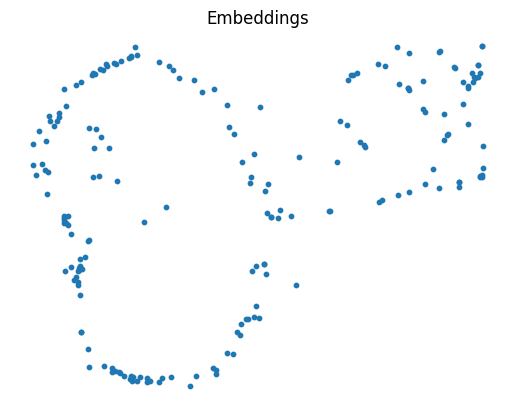

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Embeddings')
plt.axis('off')

In [32]:
def calc_global_embeddings(query, embeddings, retriever, umap_transformer, embed_function, global_embeddings):
    q_embedding = embeddings.embed_query(query)

    docs = retriever.get_relevant_documents(query)
    # print(docs)
    page_contents = [doc.page_content for doc in docs]
    vectors_content_vectors = embeddings.embed_documents(page_contents)

    query_embeddings = embed_function([q_embedding], umap_transformer)
    retrieved_embeddings = embed_function(vectors_content_vectors, umap_transformer)

    plt.figure()
    plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10, color='gray')
    plt.scatter(query_embeddings[:, 0], query_embeddings[:, 1], s=150, marker='X', color='r')
    plt.scatter(retrieved_embeddings[:, 0], retrieved_embeddings[:, 1], s=50, facecolors='none', edgecolors='g')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')
    plt.show()

100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


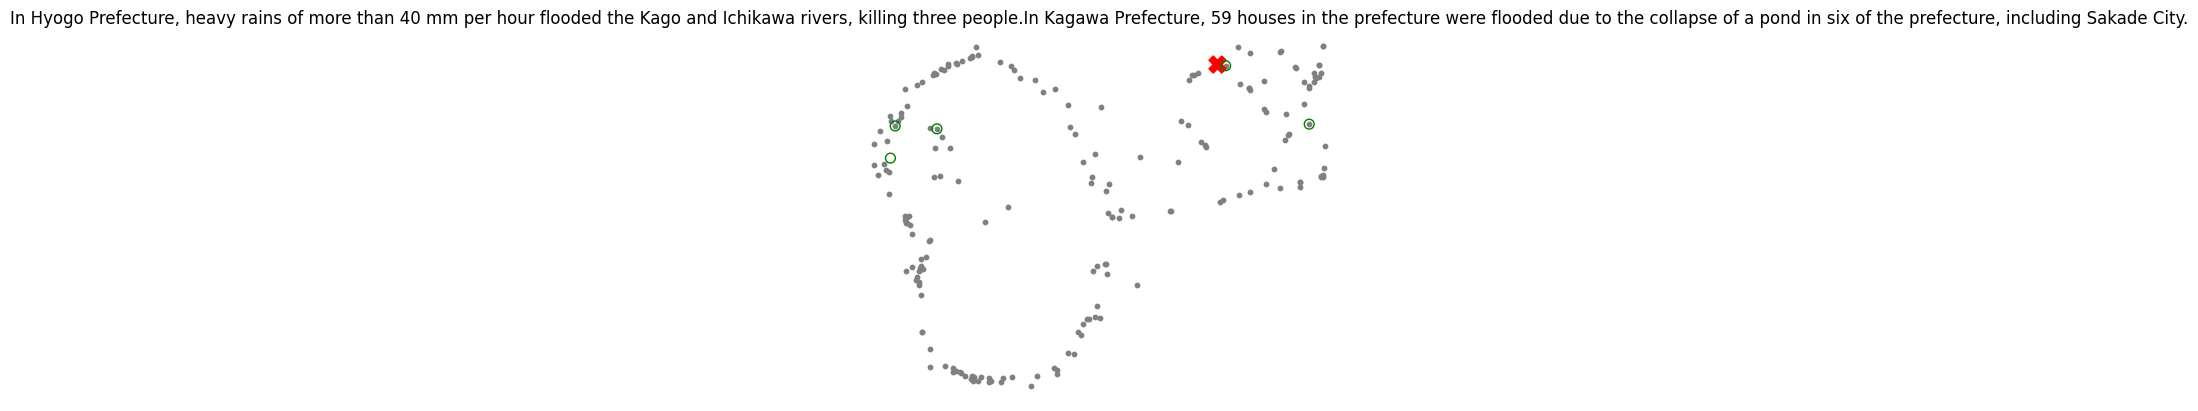

In [33]:
calc_global_embeddings("In Hyogo Prefecture, heavy rains of more than 40 mm per hour flooded the Kago and Ichikawa rivers, killing three people.In Kagawa Prefecture, 59 houses in the prefecture were flooded due to the collapse of a pond in six of the prefecture, including Sakade City.", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)
